## Notes and Observations:

At some point, we'll need to make a new dataframe of *neighborhoods* to examine patterns in them. This first run is just exploration of the dataset, but the value comes from examining neighborhoods.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [4]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

In [9]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)

## New DataFrame of Suburbs:

In [10]:
#Create new dataframe of aggregate values for each suburb
avgprice = pd.DataFrame(df.groupby('Neighborhood')['Sale Price'].agg(np.mean), columns=['Neighborhood','Sale Price'])
avgrooms = pd.DataFrame(df.groupby('Neighborhood')['Rooms'].agg(np.mean), columns=['Neighborhood','Rooms'])
avgfix = pd.DataFrame(df.groupby('Neighborhood')['Fixtures'].agg(np.mean), columns=['Neighborhood','Fixtures'])
avgyear = pd.DataFrame(df.groupby('Neighborhood')['Year Built'].agg(np.mean), columns=['Neighborhood','Year Built'])
avgsqft =pd.DataFrame(df.groupby('Neighborhood')['Square Footage Improved'].agg(np.mean), columns=['Neighborhood','Square Footage Improved'])
avgheight = pd.DataFrame(df.groupby('Neighborhood')['Story Height'].agg(np.mean), columns=['Neighborhood','Story Height'])
avglot= pd.DataFrame(df.groupby('Neighborhood')['Land Area Acres'].agg(np.mean), columns=['Neighborhood','Land Area Acres'])
nbhds=df['Neighborhood'].unique()
print(len(nbhds))

938


In [11]:
nbdf= pd.DataFrame()
nbdf['Price']=avgprice['Sale Price']
nbdf['Height']= avgheight['Story Height']
nbdf['Lot Size']= avglot['Land Area Acres']
nbdf['Year Built']=avgyear['Year Built']
nbdf['SqFt']=avgsqft['Square Footage Improved']
nbdf['Fixtures']=avgfix['Fixtures']
#subdf['Suburb']=burbs
nbdf=nbdf.dropna()
print(nbdf.head())

                     Price    Height  Lot Size   Year Built         SqFt  \
Neighborhood                                                               
0107          6.074500e+05  1.516484  0.402500  1963.615385  6375.587963   
0126          4.600734e+05  1.646026  0.137577  1981.263401  1149.117984   
0226          2.415812e+05  1.228468  0.171150  1963.595003  1040.952690   
0306          2.000000e+06  1.422222  0.867927  1967.672222  5139.353167   
0326          3.346626e+05  1.428105  0.306552  1968.490196  1248.698730   

               Fixtures  
Neighborhood             
0107           3.196429  
0126          10.205800  
0226           7.985392  
0306           1.936508  
0326           9.229730  


In [ ]:
nbdf.shape

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
X= nbdf[['Lot Size','Year Built','SqFt','Height','Price', 'Fixtures']]
data = pd.DataFrame(scale(X), columns=['Lot Size','Year Built','SqFt','Height','Price', 'Fixtures'])

pca = PCA(n_components=4).fit(data)
pca_samples= pca.transform(data)
print(data.head())

   Lot Size  Year Built      SqFt    Height     Price  Fixtures
0 -0.012792   -1.195467  2.848840 -0.018410  0.305110 -2.102849
1 -0.252544   -0.327776 -0.379225  0.289073  0.096274  0.284551
2 -0.222161   -1.196469 -0.446032 -0.702048 -0.213335 -0.471723
3  0.408413   -0.996007  2.085295 -0.242151  2.278388 -2.531980
4 -0.099624   -0.955790 -0.317720 -0.228188 -0.081437 -0.047900


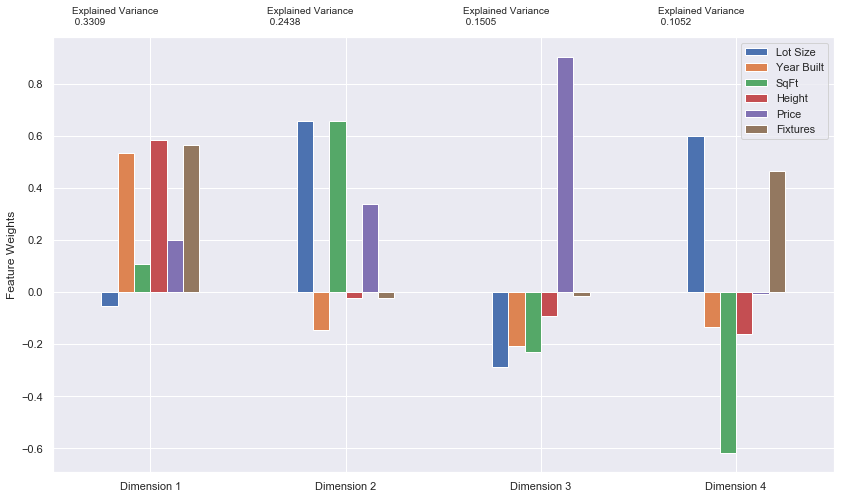

In [13]:
def pca_results(data, pca):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)
    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(data, pca)

In [14]:
pca_results.cumsum()

,Explained Variance,Lot Size,Year Built,SqFt,Height,Price,Fixtures
Dimension 1,0.3309,-0.0523,0.5336,0.1066,0.5847,0.2003,0.5650
Dimension 2,0.5747,0.6047,0.3875,0.7630,0.5630,0.5397,0.5421
Dimension 3,0.7252,0.3177,0.1796,0.5341,0.4724,1.4417,0.5290
Dimension 4,0.8304,0.9173,0.0466,-0.0818,0.3111,1.4361,0.9953


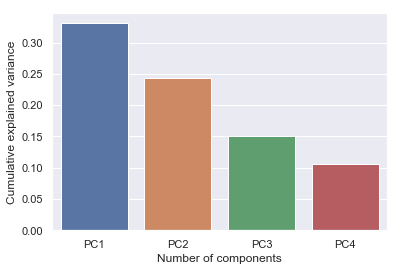

In [15]:
dfvar = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var",  
           data=dfvar);
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [16]:
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [17]:
def biplot(data, reduced_data, pca):
    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    feature_vectors = pca.components_.T
    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,
    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)
    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

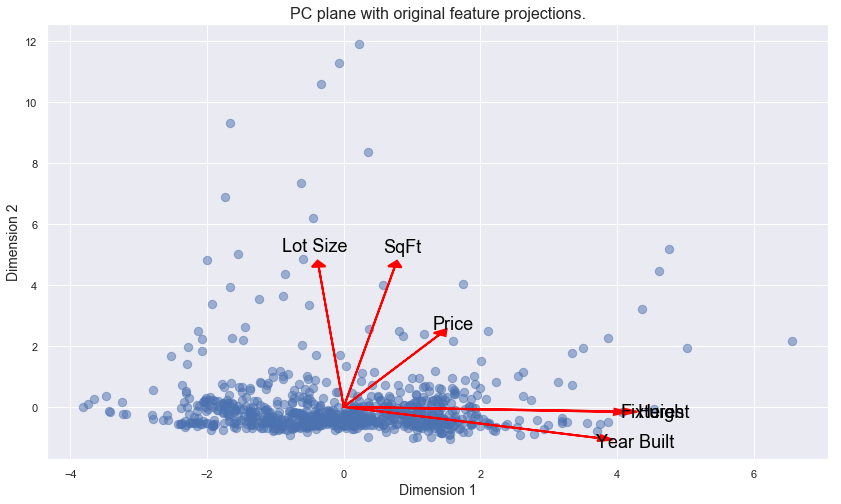

In [18]:
biplot(data, reduced_data, pca)

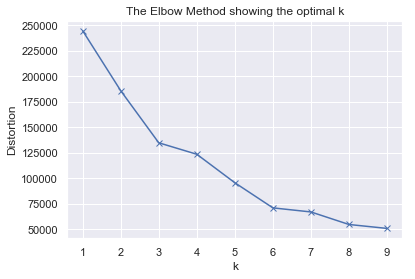

In [19]:
#Determine k using elbow method
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

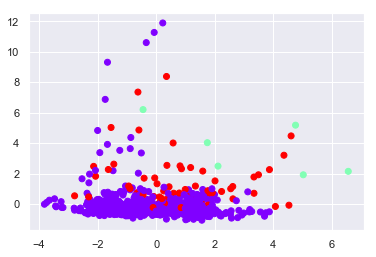

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
data['cluster'] = pd.Series(labels)
plt.scatter(reduced_data['Dimension 1'],reduced_data['Dimension 2'], c=kmeans.labels_, cmap='rainbow')

## Next step: analysis of neighborhoods


In [2]:
len(nbdf).value_counts()

NameError: name 'nbdf' is not defined